In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np

# === Thiết bị ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Config ===
img_size = 224
batch_size = 32
num_classes = 6
model_path = "D:/KLTN/SKINTONE/mobilenetv2_best_cheek_chin.pth"
test_dir = "D:/KLTN/SKINTONE/public/data_4/data_train/test"

# === Transform giống khi huấn luyện ===
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


C:\Users\admin1\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load lại MobileNetV2 + sửa classifier
model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, num_classes)
)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [3]:
# Tải dữ liệu test
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hàm đánh giá
def evaluate(model, loader):
    all_preds, all_labels = [], []
    criterion = nn.CrossEntropyLoss()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    acc = total_correct / len(loader.dataset)
    return avg_loss, acc, all_labels, all_preds

# Gọi hàm
test_loss, test_acc, test_labels, test_preds = evaluate(model, test_loader)
print(f"✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")


✅ Test Accuracy: 0.9898 | Loss: 0.0311


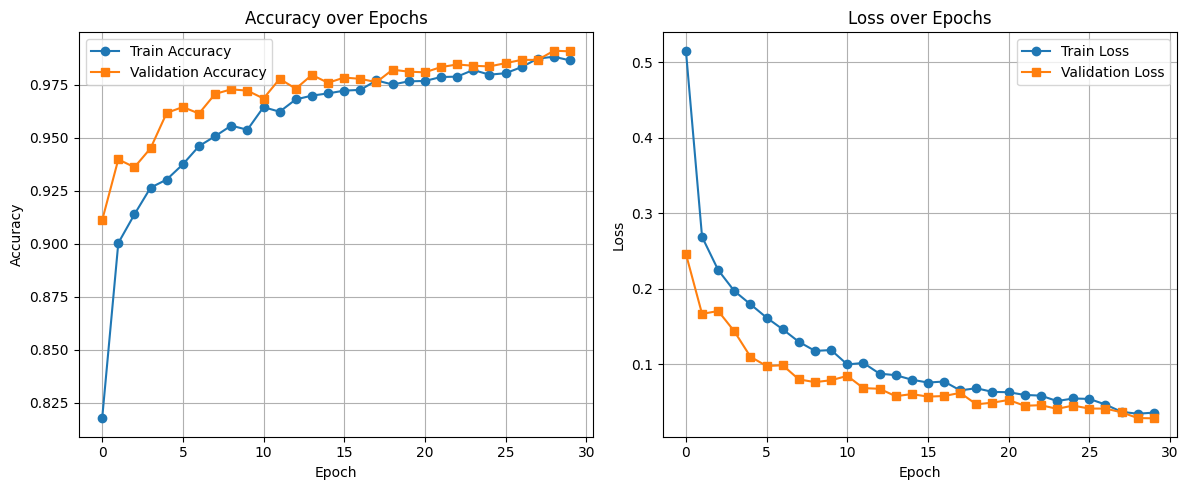

In [5]:
import json
import matplotlib.pyplot as plt

with open("D:/KLTN/SKINTONE/mobilenetv2_history_best_cheek_chin.json", "r") as f:
    history = json.load(f)



plt.figure(figsize=(12, 5))

# === Accuracy ===
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# === Loss ===
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



📊 Classification Report:
              precision    recall  f1-score   support

      Type_1       1.00      1.00      1.00       360
      Type_2       0.99      0.97      0.98       360
      Type_3       0.96      0.99      0.97       360
      Type_4       0.99      0.98      0.99       360
      Type_5       1.00      1.00      1.00       360
      Type_6       1.00      1.00      1.00       360

    accuracy                           0.99      2160
   macro avg       0.99      0.99      0.99      2160
weighted avg       0.99      0.99      0.99      2160



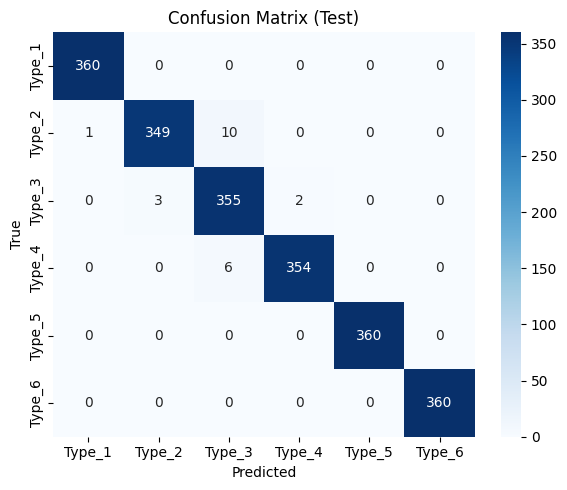

In [4]:
# Báo cáo phân loại
print("📊 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes))

# Vẽ confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


In [6]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapipe as mp

# ===== Cấu hình chung =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
class_names = ["Type_1", "Type_2", "Type_3", "Type_4", "Type_5", "Type_6"]

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ===== Load mô hình =====
model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[1].in_features, 128),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128, 6)
)
model.load_state_dict(torch.load("D:/KLTN/SKINTONE/mobilenetv2_history_best_cheek_chin.pth", map_location=device))
model.to(device)
model.eval()

# ===== Landmark vùng má trái/phải và cằm =====
LEFT_CHEEK = [234, 93, 132, 58, 172, 136, 205, 50]
RIGHT_CHEEK = [454, 323, 361, 288, 397, 365, 425, 280]
CHIN = [204,149,148,152,377,400,378,424,406,18,182,204]

# ===== Hàm cắt vùng (má/cằm) =====
def crop_region(image, landmarks, ids):
    h, w = image.shape[:2]
    pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in ids], np.int32)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    region = cv2.bitwise_and(image, image, mask=mask)
    gray_bg = np.full_like(image, 128)
    blended = np.where(mask[:, :, None] == 255, region, gray_bg)
    x, y, w_box, h_box = cv2.boundingRect(pts)
    return blended[y:y+h_box, x:x+w_box]

# ===== Hàm chính =====
def normalize_lightness(region, target_L=80):
    lab = cv2.cvtColor(region, cv2.COLOR_RGB2Lab)
    current_L = np.mean(lab[:, :, 0])
    if current_L < 1: current_L = 1  # tránh chia cho 0
    scale = target_L / current_L
    lab[:, :, 0] = np.clip(lab[:, :, 0] * scale, 0, 100)
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def predict_folder_voting(folder_path, limit=5, save_csv="results_voting.csv"):
    mp_face_mesh = mp.solutions.face_mesh
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    results_list = []
    count = 0
    os.makedirs("debug_combined", exist_ok=True)

    for filename in tqdm(os.listdir(folder_path), desc="Đang xử lý"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.png')):
            continue

        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue

        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ih, iw = img_rgb.shape[:2]

        result = face_mesh.process(img_rgb)
        if not result.multi_face_landmarks:
            print(f"{filename} Không tìm thấy khuôn mặt")
            continue

        landmarks = result.multi_face_landmarks[0].landmark

        # ==== Tạo mặt che mắt miệng ====
        face_contour = [10,338,297,332,284,251,389,356,454,323,361,288,397,
                        365,379,378,400,377,152,148,176,149,150,136,172,
                        58,132,93,234,127,162,21,54,103,67,109]
        face_points = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in face_contour], np.int32)
        face_mask = np.zeros((ih, iw), dtype=np.uint8)
        cv2.fillPoly(face_mask, [face_points], 255)

        # Che mắt và miệng
        for region in [
            [33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7],
            [362,398,384,385,386,387,388,466,263,249,390,373,374,380,381,382],
            [61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146,61]
        ]:
            pts = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in region], np.int32)
            cv2.fillPoly(face_mask, [pts], 0)

        seg = selfie_segmentation.process(img_rgb)
        seg_mask = (seg.segmentation_mask > 0.9).astype(np.uint8) * 255
        seg_mask = cv2.GaussianBlur(seg_mask, (7, 7), sigmaX=3)
        seg_mask = (seg_mask > 127).astype(np.uint8) * 255

        comb_mask = cv2.bitwise_and(face_mask, seg_mask)
        masked = cv2.bitwise_and(img_rgb, img_rgb, mask=comb_mask)
        gray_bg = np.full_like(img_rgb, 128)
        img_with_gray_bg = np.where(comb_mask[:, :, None] == 255, masked, gray_bg)

        x, y, w_box, h_box = cv2.boundingRect(face_points)
        face_crop = img_with_gray_bg[y:y+h_box, x:x+w_box]

        # ==== Trích má trái, phải, cằm ====
        regions = {
            "left": crop_region(img_with_gray_bg, landmarks, LEFT_CHEEK),
            "right": crop_region(img_with_gray_bg, landmarks, RIGHT_CHEEK),
            "chin": crop_region(img_with_gray_bg, landmarks, CHIN)
        }

        predictions = {}
        voting = []

        for name, region in regions.items():
            if region.size == 0 or region.shape[0] < 20 or region.shape[1] < 20:
                continue
            lab = cv2.cvtColor(region, cv2.COLOR_RGB2Lab)
            L_mean = np.mean(lab[:, :, 0])
            if L_mean < 50:
                continue

            pil_img = Image.fromarray(region).convert("RGB")
            input_tensor = val_transform(pil_img).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
                pred = output.argmax(dim=1).item()
                label = class_names[pred]
                voting.append(label)
                predictions[name] = (label, L_mean)

        if not voting:
            print(f"{filename} Không có vùng đủ sáng")
            continue

        voted_label = Counter(voting).most_common(1)[0][0]

        # ==== Gộp 3 vùng lại ====
       # ==== Gộp 3 vùng lại ====
        combined_label = "N/A"
        combined_image = None
        if all(regions[k].size > 0 for k in ["left", "right", "chin"]):
            # Không chuẩn hóa sáng ở đây
            # Resize má trái, phải
            target_h = 150
            resized_cheeks = []
            for k in ["left", "right"]:
                h, w = regions[k].shape[:2]
                scale = target_h / h
                resized = cv2.resize(regions[k], (int(w * scale), target_h))
                resized_cheeks.append(resized)
            top_row = cv2.hconcat(resized_cheeks)

            # Resize cằm theo chiều rộng hàng trên
            chin = regions["chin"]
            chin_h, chin_w = chin.shape[:2]
            scale_chin = top_row.shape[1] / chin_w
            chin_resized = cv2.resize(chin, (top_row.shape[1], int(chin_h * scale_chin)))

            combined_image = cv2.vconcat([top_row, chin_resized])

            # Dự đoán từ ảnh gộp
            pil_combined = Image.fromarray(combined_image).convert("RGB")
            input_tensor_combined = val_transform(pil_combined).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor_combined)
                pred = output.argmax(dim=1).item()
                combined_label = class_names[pred]
            print(f"{filename}  Gộp 3 vùng ➜ {combined_label}")

            # Lưu ảnh gộp nếu cần
            debug_save = f"debug_combined/{os.path.splitext(filename)[0]}_combined.jpg"
            cv2.imwrite(debug_save, cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))

        # === Lưu kết quả
        results_list.append((filename, voted_label, combined_label, voting))

        # === Hiển thị
        if count < limit:
            fig, axs = plt.subplots(1, 6, figsize=(18, 4))
            axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Ảnh gốc")
            axs[0].axis("off")

            axs[1].imshow(face_crop)
            axs[1].set_title("Mặt xử lý")
            axs[1].axis("off")

            i = 2
            for name in ["left", "right", "chin"]:
                if name in predictions:
                    label, L = predictions[name]
                    axs[i].imshow(regions[name])
                    axs[i].set_title(f"{name.upper()}\n{label} (L={L:.1f})")
                    axs[i].axis("off")
                    i += 1

            if combined_image is not None:
                axs[i].imshow(combined_image)
                axs[i].set_title(f"Gộp 3 ➜ {combined_label}")
                axs[i].axis("off")

            plt.tight_layout()
            plt.show()
            count += 1

    if results_list:
        df = pd.DataFrame(results_list, columns=["Image", "Voting_Prediction", "Combined_Prediction", "Votes"])
        df.to_csv(save_csv, index=False, encoding="utf-8-sig")
        print(f"\nĐã lưu kết quả tại: {save_csv}")
    else:
        print("Không ảnh nào được xử lý.")


# ===== Gọi thử =====
predict_folder_voting("../public/test4", limit=20)


FileNotFoundError: [Errno 2] No such file or directory: 'D:/KLTN/SKINTONE/mobilenetv2_history_best_cheek_chin.pth'

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapipe as mp
from collections import OrderedDict

# ===== Cấu hình =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
class_names = ["Type_1", "Type_2", "Type_3", "Type_4", "Type_5", "Type_6"]

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[1].in_features, 128),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128, 6)
)
model.load_state_dict(torch.load("../mobilenetv2_best_cheek_chin.pth", map_location=device))
model.to(device)
model.eval()

LEFT_CHEEK = [234, 93, 132, 58, 172, 136, 205, 50]
RIGHT_CHEEK = [454, 323, 361, 288, 397, 365, 425, 280]
CHIN = [204,149,148,152,377,400,378,424,406,18,182,204]


def crop_region(image, landmarks, ids):
    h, w = image.shape[:2]
    pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in ids], np.int32)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    region = cv2.bitwise_and(image, image, mask=mask)
    gray_bg = np.full_like(image, 128)
    blended = np.where(mask[:, :, None] == 255, region, gray_bg)
    x, y, w_box, h_box = cv2.boundingRect(pts)
    return blended[y:y+h_box, x:x+w_box]


def is_valid_region(region, min_size=20, min_lightness=50):
    if region is None or region.size == 0:
        return False
    h, w = region.shape[:2]
    if h < min_size or w < min_size:
        return False
    lab = cv2.cvtColor(region, cv2.COLOR_RGB2Lab)
    L_mean = np.mean(lab[:, :, 0])
    return L_mean >= min_lightness


def predict_folder(folder_path, limit=10, save_csv="results_combined_only.csv"):
    mp_face_mesh = mp.solutions.face_mesh
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    os.makedirs("debug_combined", exist_ok=True)
    results_list = []
    count = 0

    for filename in tqdm(os.listdir(folder_path), desc="Dự đoán"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue

        path = os.path.join(folder_path, filename)
        image = cv2.imread(path)
        if image is None:
            continue
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ih, iw = img_rgb.shape[:2]

        result = face_mesh.process(img_rgb)
        if not result.multi_face_landmarks:
            print(f"{filename} Không tìm thấy khuôn mặt")
            continue
        landmarks = result.multi_face_landmarks[0].landmark

        # ==== Tạo mặt nạ khuôn mặt (loại bỏ mắt-miệng) ====
        face_contour = [10,338,297,332,284,251,389,356,454,323,361,288,397,
                        365,379,378,400,377,152,148,176,149,150,136,172,
                        58,132,93,234,127,162,21,54,103,67,109]
        face_points = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in face_contour], np.int32)
        face_mask = np.zeros((ih, iw), dtype=np.uint8)
        cv2.fillPoly(face_mask, [face_points], 255)

        for region in [[33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7],
                       [362,398,384,385,386,387,388,466,263,249,390,373,374,380,381,382],
                       [61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146,61]]:
            pts = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in region], np.int32)
            cv2.fillPoly(face_mask, [pts], 0)

        seg = selfie_segmentation.process(img_rgb)
        seg_mask = (seg.segmentation_mask > 0.9).astype(np.uint8) * 255
        seg_mask = cv2.GaussianBlur(seg_mask, (7, 7), sigmaX=3)
        seg_mask = (seg_mask > 127).astype(np.uint8) * 255

        comb_mask = cv2.bitwise_and(face_mask, seg_mask)
        masked = cv2.bitwise_and(img_rgb, img_rgb, mask=comb_mask)
        gray_bg = np.full_like(img_rgb, 128)
        img_with_gray_bg = np.where(comb_mask[:, :, None] == 255, masked, gray_bg)

        x, y, w_box, h_box = cv2.boundingRect(face_points)
        face_crop = img_with_gray_bg[y:y+h_box, x:x+w_box]

        regions = OrderedDict({
            "left": crop_region(img_with_gray_bg, landmarks, LEFT_CHEEK),
            "right": crop_region(img_with_gray_bg, landmarks, RIGHT_CHEEK),
            "chin": crop_region(img_with_gray_bg, landmarks, CHIN),
        })

        valid_regions = {k: v for k, v in regions.items() if is_valid_region(v)}
        if len(valid_regions) < 2:
            print(f"{filename} Không đủ vùng hợp lệ để ghép")
            continue

        # ==== Ghép các vùng hợp lệ ====
        target_h = 150
        top_row = []
        bottom_row = None
        for k in ["left", "right"]:
            if k in valid_regions:
                h, w = valid_regions[k].shape[:2]
                scale = target_h / h
                resized = cv2.resize(valid_regions[k], (int(w * scale), target_h))
                top_row.append(resized)
        if "chin" in valid_regions:
            chin = valid_regions["chin"]
            chin_h, chin_w = chin.shape[:2]
            scale_chin = (sum([img.shape[1] for img in top_row]) if top_row else chin_w) / chin_w
            bottom_row = cv2.resize(chin, (int(chin_w * scale_chin), int(chin_h * scale_chin)))

        combined = None

        if top_row:
            top = cv2.hconcat(top_row)
            if bottom_row is not None:
                # Resize bottom_row (vùng cằm) để có chiều rộng bằng top
                bottom_resized = cv2.resize(bottom_row, (top.shape[1], bottom_row.shape[0]))
                combined = cv2.vconcat([top, bottom_resized])
            else:
                combined = top
        elif bottom_row is not None:
            combined = bottom_row

        pil_combined = Image.fromarray(combined).convert("RGB")
        input_tensor = val_transform(pil_combined).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()
            label = class_names[pred]
        print(f"{filename}  Dự đoán ➜ {label}")

        # Lưu debug ảnh
        save_path = f"debug_combined/{os.path.splitext(filename)[0]}_combined.jpg"
        cv2.imwrite(save_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))

        results_list.append((filename, label))

        # Hiển thị
        if count < limit:
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Ảnh gốc")
            axs[1].imshow(face_crop)
            axs[1].set_title("Mặt xử lý")
            axs[2].imshow(combined)
            axs[2].set_title(f"Ảnh ghép ➜ {label}")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
            count += 1

    if results_list:
        df = pd.DataFrame(results_list, columns=["Image", "Prediction"])
        df.to_csv(save_csv, index=False, encoding="utf-8-sig")
        print(f"\nĐã lưu kết quả tại: {save_csv}")
    else:
        print(" Không ảnh nào được xử lý.")

# Gọi thử (sử dụng đường dẫn tương đối tới workspace)
predict_folder("../public/test4", limit=10)


AttributeError: module 'mediapipe' has no attribute 'solutions'

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapipe as mp
from collections import OrderedDict
from skimage.color import rgb2lab

# ===== Cấu hình =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
class_names = ["Type_1", "Type_2", "Type_3", "Type_4", "Type_5", "Type_6"]

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[1].in_features, 128),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128, 6)
)
model.load_state_dict(torch.load("../mobilenetv2_best_cheek_chin.pth", map_location=device))
model.to(device)
model.eval()

LEFT_CHEEK = [234, 93, 132, 58, 172, 136, 205, 50]
RIGHT_CHEEK = [454, 323, 361, 288, 397, 365, 425, 280]
CHIN = [204,149,148,152,377,400,378,424,406,18,182,204]

def crop_region(image, landmarks, ids):
    h, w = image.shape[:2]
    pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in ids], np.int32)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    region = cv2.bitwise_and(image, image, mask=mask)
    gray_bg = np.full_like(image, 128)
    blended = np.where(mask[:, :, None] == 255, region, gray_bg)
    x, y, w_box, h_box = cv2.boundingRect(pts)
    return blended[y:y+h_box, x:x+w_box]

def is_valid_region(region, min_size=20, min_lightness=50):
    if region is None or region.size == 0:
        return False
    h, w = region.shape[:2]
    if h < min_size or w < min_size:
        return False
    lab = cv2.cvtColor(region, cv2.COLOR_RGB2Lab)
    L_mean = np.mean(lab[:, :, 0])
    return L_mean >= min_lightness

def get_lab_mean(region):
    lab = rgb2lab(region)
    return np.mean(lab[:, :, 0]), np.mean(lab[:, :, 1]), np.mean(lab[:, :, 2])

def delta_e(c1, c2):
    return np.linalg.norm(np.array(c1) - np.array(c2))

def remove_color_outlier(regions, threshold=12, debug_name=""):
    if len(regions) < 2:
        return regions

    lab_means = {k: get_lab_mean(v) for k, v in regions.items()}
    keys = list(lab_means.keys())

    if len(keys) == 2:
        return regions

    # Tính ΔE giữa từng cặp vùng
    pairwise_de = {}
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys):
            if i < j:
                pairwise_de[(k1, k2)] = delta_e(lab_means[k1], lab_means[k2])

    print(f"[{debug_name}] ΔE giữa từng cặp:")
    for (a, b), de in pairwise_de.items():
        print(f"  {a} vs {b}: {de:.2f}")

    # Tính ΔE trung bình mỗi vùng
    region_de = {
        k: np.mean([delta_e(lab_means[k], lab_means[o]) for o in keys if o != k])
        for k in keys
    }
    print(f"[{debug_name}] ΔE trung bình:", {k: f"{v:.2f}" for k, v in region_de.items()})

    # Kiểm tra nếu có 2 vùng gần nhau và vùng còn lại cách xa cả hai
    pair_list = list(pairwise_de.items())
    for (a, b), d_ab in pair_list:
        c = [k for k in keys if k != a and k != b][0]
        d_ac = delta_e(lab_means[a], lab_means[c])
        d_bc = delta_e(lab_means[b], lab_means[c])
        if d_ab < threshold and d_ac > threshold and d_bc > threshold:
            print(f"[{debug_name}] {a} & {b} gần nhau ➜ Loại bỏ vùng lệch: {c}")
            regions.pop(c)
            return regions

    # Nếu không thoả điều kiện trên, fallback về cách sắp xếp ΔE trung bình
    sorted_regions = sorted(region_de.items(), key=lambda x: x[1])  # tăng dần
    d1, d2, d3 = sorted_regions[0][1], sorted_regions[1][1], sorted_regions[2][1]

    if abs(d1 - d2) < threshold and abs(d2 - d3) > threshold:
        outlier = sorted_regions[2][0]
        print(f"[{debug_name}] Hai vùng gần ➜ Loại bỏ vùng lệch: {outlier}")
        regions.pop(outlier)
    elif abs(d1 - d2) > threshold and abs(d2 - d3) < threshold:
        outlier = sorted_regions[0][0]
        print(f"[{debug_name}] Hai vùng lệch ➜ Loại bỏ vùng thấp nhất: {outlier}")
        regions.pop(outlier)
    elif (d3 - d1) > threshold * 2:
        outlier = sorted_regions[2][0]
        print(f"[{debug_name}] Lệch mạnh ➜ Loại bỏ: {outlier}")
        regions.pop(outlier)

    return regions


def predict_folder(folder_path, limit=10, save_csv="results_combined_only.csv"):
    mp_face_mesh = mp.solutions.face_mesh
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    os.makedirs("debug_combined", exist_ok=True)
    results_list = []
    count = 0

    for filename in tqdm(os.listdir(folder_path), desc="Dự đoán"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue

        path = os.path.join(folder_path, filename)
        image = cv2.imread(path)
        if image is None:
            continue
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ih, iw = img_rgb.shape[:2]

        result = face_mesh.process(img_rgb)
        if not result.multi_face_landmarks:
            print(f"{filename} Không tìm thấy khuôn mặt")
            continue
        landmarks = result.multi_face_landmarks[0].landmark

        # Tạo mặt nạ khuôn mặt (loại bỏ mắt-miệng)
        face_contour = [10,338,297,332,284,251,389,356,454,323,361,288,397,
                        365,379,378,400,377,152,148,176,149,150,136,172,
                        58,132,93,234,127,162,21,54,103,67,109]
        face_points = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in face_contour], np.int32)
        face_mask = np.zeros((ih, iw), dtype=np.uint8)
        cv2.fillPoly(face_mask, [face_points], 255)

        for region in [[33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7],
                       [362,398,384,385,386,387,388,466,263,249,390,373,374,380,381,382],
                       [61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146,61]]:
            pts = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in region], np.int32)
            cv2.fillPoly(face_mask, [pts], 0)

        seg = selfie_segmentation.process(img_rgb)
        seg_mask = (seg.segmentation_mask > 0.9).astype(np.uint8) * 255
        seg_mask = cv2.GaussianBlur(seg_mask, (7, 7), sigmaX=3)
        seg_mask = (seg_mask > 127).astype(np.uint8) * 255

        comb_mask = cv2.bitwise_and(face_mask, seg_mask)
        masked = cv2.bitwise_and(img_rgb, img_rgb, mask=comb_mask)
        gray_bg = np.full_like(img_rgb, 128)
        img_with_gray_bg = np.where(comb_mask[:, :, None] == 255, masked, gray_bg)

        x, y, w_box, h_box = cv2.boundingRect(face_points)
        face_crop = img_with_gray_bg[y:y+h_box, x:x+w_box]

        regions = OrderedDict({
            "left": crop_region(img_with_gray_bg, landmarks, LEFT_CHEEK),
            "right": crop_region(img_with_gray_bg, landmarks, RIGHT_CHEEK),
            "chin": crop_region(img_with_gray_bg, landmarks, CHIN),
        })

        valid_regions = {k: v for k, v in regions.items() if is_valid_region(v)}
        valid_regions = remove_color_outlier(valid_regions, threshold=12, debug_name=filename)

        if len(valid_regions) < 2:
            print(f"{filename} Không đủ vùng hợp lệ sau khi loại lệch màu")
            continue

        target_h = 150
        top_row = []
        bottom_row = None
        for k in ["left", "right"]:
            if k in valid_regions:
                h, w = valid_regions[k].shape[:2]
                scale = target_h / h
                resized = cv2.resize(valid_regions[k], (int(w * scale), target_h))
                top_row.append(resized)
        if "chin" in valid_regions:
            chin = valid_regions["chin"]
            chin_h, chin_w = chin.shape[:2]
            scale_chin = (sum([img.shape[1] for img in top_row]) if top_row else chin_w) / chin_w
            bottom_row = cv2.resize(chin, (int(chin_w * scale_chin), int(chin_h * scale_chin)))

        combined = None
        if top_row:
            top = cv2.hconcat(top_row)
            if bottom_row is not None:
                bottom_resized = cv2.resize(bottom_row, (top.shape[1], bottom_row.shape[0]))
                combined = cv2.vconcat([top, bottom_resized])
            else:
                combined = top
        elif bottom_row is not None:
            combined = bottom_row

        pil_combined = Image.fromarray(combined).convert("RGB")
        input_tensor = val_transform(pil_combined).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()
            label = class_names[pred]
        print(f"{filename}  Dự đoán ➔ {label}")

        save_path = f"debug_combined/{os.path.splitext(filename)[0]}_combined.jpg"
        cv2.imwrite(save_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))

        results_list.append((filename, label))

        if count < limit:
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Ảnh gốc")
            axs[1].imshow(face_crop)
            axs[1].set_title("Mặt xử lý")
            axs[2].imshow(combined)
            axs[2].set_title(f"Ảnh ghép ➔ {label}")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
            count += 1

    if results_list:
        df = pd.DataFrame(results_list, columns=["Image", "Prediction"])
        df.to_csv(save_csv, index=False, encoding="utf-8-sig")
        print(f"\nĐã lưu kết quả tại: {save_csv}")
    else:
        print("Không ảnh nào được xử lý.")

# ===== Gọi thử =====
predict_folder("../public/test4", limit=10)


In [ ]:
import mediapipe as mp
print(mp)
print(mp.__file__)


<module 'mediapipe' from 'C:\\Users\\XuanQuynh\\AppData\\Roaming\\Python\\Python311\\site-packages\\mediapipe\\__init__.py'>
C:\Users\XuanQuynh\AppData\Roaming\Python\Python311\site-packages\mediapipe\__init__.py


Dự đoán:   0%|          | 0/13 [00:00<?, ?it/s]

[1.jpg] ΔE giữa từng cặp:
  left vs right: 7.16
  left vs chin: 10.98
  right vs chin: 3.88
[1.jpg] ΔE trung bình: {'right': '5.52', 'chin': '7.43', 'left': '9.07'}
1.jpg 🧩 Dự đoán ➔ Type_1


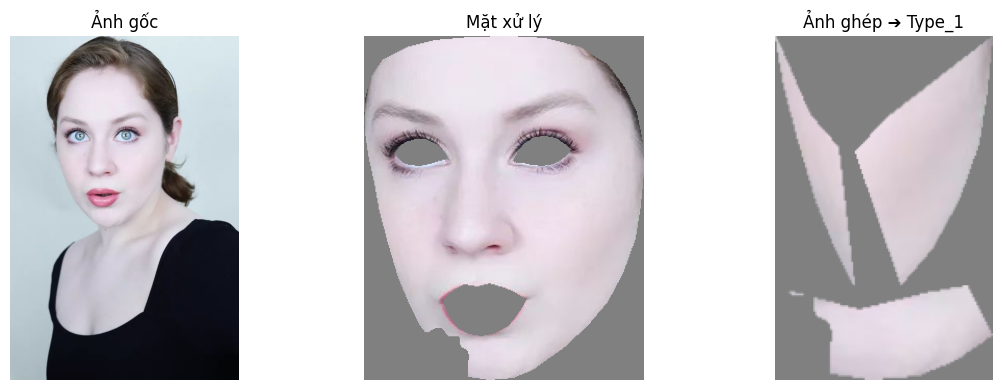

Dự đoán:   8%|▊         | 1/13 [00:00<00:03,  3.48it/s]

[2.jpg] ΔE giữa từng cặp:
  left vs right: 17.71
  left vs chin: 8.39
  right vs chin: 12.12
[2.jpg] ΔE trung bình: {'left': '13.05', 'chin': '10.26', 'right': '14.91'}
[2.jpg] ✅ left & chin gần nhau ➜ Loại bỏ vùng lệch: right
2.jpg 🧩 Dự đoán ➔ Type_1


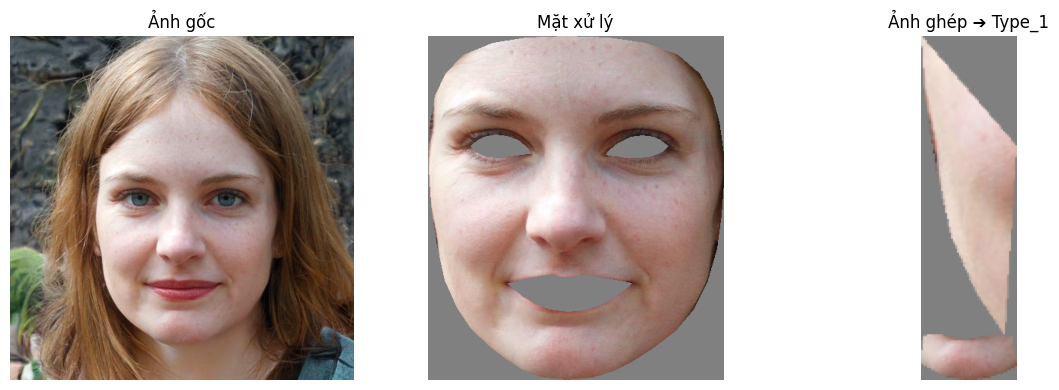

Dự đoán:  15%|█▌        | 2/13 [00:00<00:03,  3.39it/s]

[28b3a176734f2aeb9e64e6bf3bd2c171.jpg] ΔE giữa từng cặp:
  left vs right: 12.23
  left vs chin: 2.19
  right vs chin: 10.06
[28b3a176734f2aeb9e64e6bf3bd2c171.jpg] ΔE trung bình: {'left': '7.21', 'chin': '6.12', 'right': '11.15'}
28b3a176734f2aeb9e64e6bf3bd2c171.jpg 🧩 Dự đoán ➔ Type_4


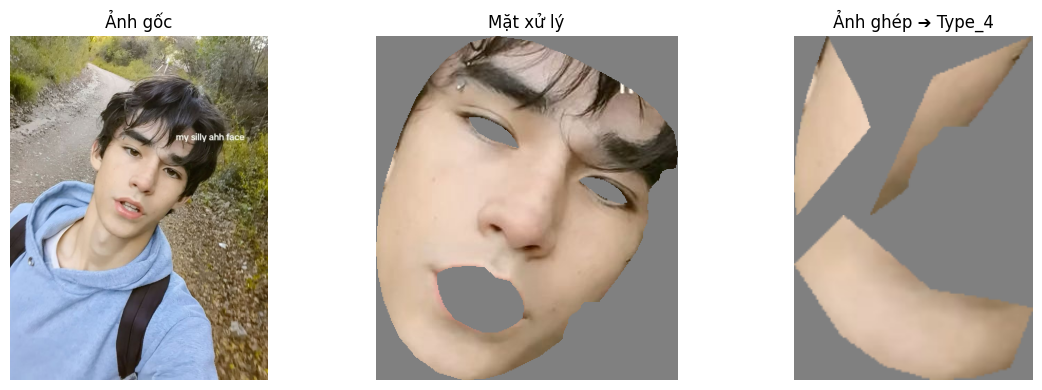

Dự đoán:  23%|██▎       | 3/13 [00:00<00:03,  3.19it/s]

[3.jpg] ΔE giữa từng cặp:
  left vs right: 10.41
  left vs chin: 9.76
  right vs chin: 12.04
[3.jpg] ΔE trung bình: {'left': '10.08', 'chin': '10.90', 'right': '11.22'}
3.jpg 🧩 Dự đoán ➔ Type_4


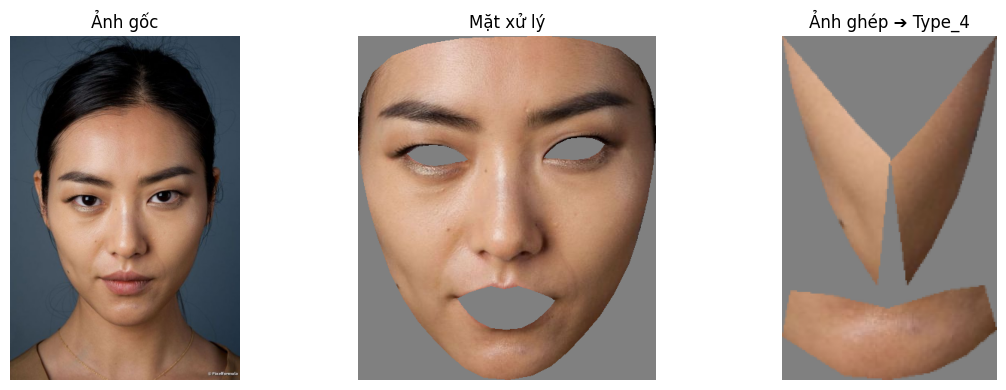

Dự đoán:  31%|███       | 4/13 [00:01<00:03,  2.98it/s]

[3cc4ac91c833677ae2f812f09d0358d5.jpg] ΔE giữa từng cặp:
  left vs right: 2.56
  left vs chin: 10.07
  right vs chin: 10.98
[3cc4ac91c833677ae2f812f09d0358d5.jpg] ΔE trung bình: {'left': '6.32', 'right': '6.77', 'chin': '10.52'}
3cc4ac91c833677ae2f812f09d0358d5.jpg 🧩 Dự đoán ➔ Type_3


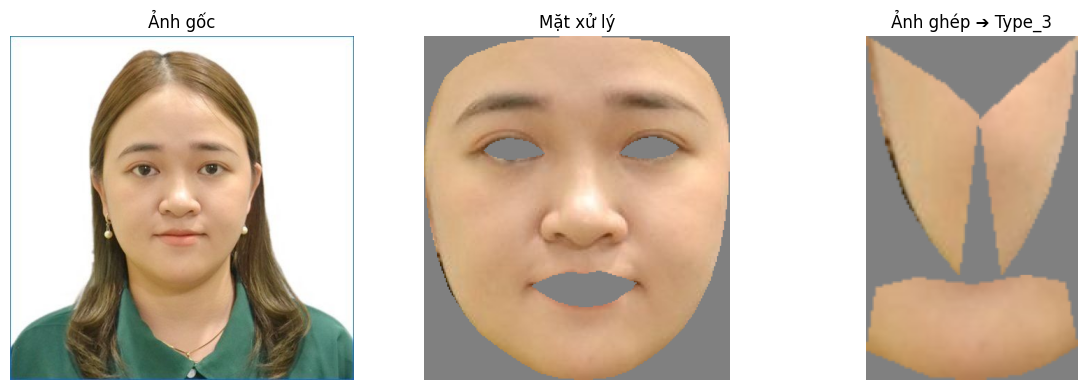

Dự đoán:  38%|███▊      | 5/13 [00:01<00:02,  3.21it/s]

[4.jpg] ΔE giữa từng cặp:
  left vs right: 3.21
  left vs chin: 10.30
  right vs chin: 9.06
[4.jpg] ΔE trung bình: {'left': '6.76', 'right': '6.14', 'chin': '9.68'}
4.jpg 🧩 Dự đoán ➔ Type_4


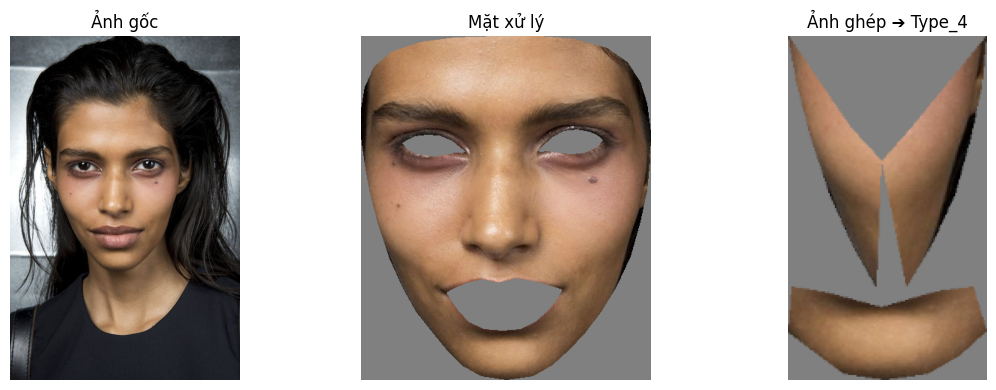

Dự đoán:  46%|████▌     | 6/13 [00:01<00:02,  3.09it/s]

[5.jpg] ΔE giữa từng cặp:
  left vs right: 0.84
  left vs chin: 15.82
  right vs chin: 15.14
[5.jpg] ΔE trung bình: {'left': '8.33', 'right': '7.99', 'chin': '15.48'}
[5.jpg] ✅ left & right gần nhau ➜ Loại bỏ vùng lệch: chin
5.jpg 🧩 Dự đoán ➔ Type_1


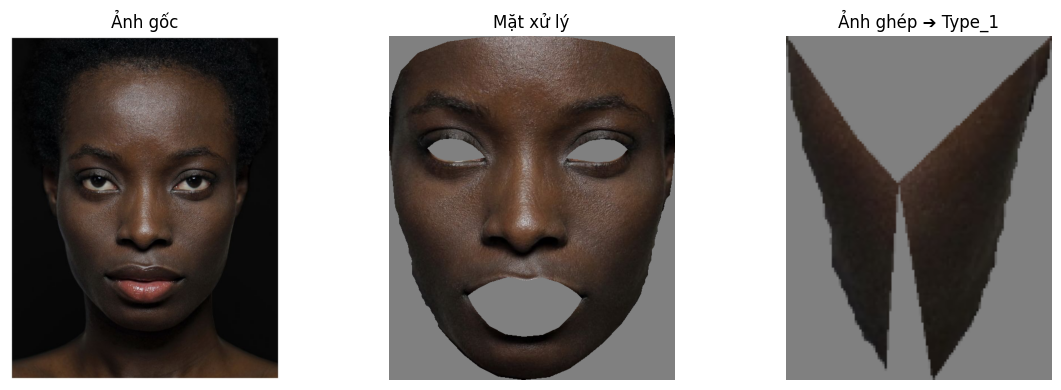

Dự đoán:  54%|█████▍    | 7/13 [00:02<00:01,  3.09it/s]

[6.jpg] ΔE giữa từng cặp:
  left vs right: 0.27
  left vs chin: 5.57
  right vs chin: 5.54
[6.jpg] ΔE trung bình: {'left': '2.92', 'right': '2.90', 'chin': '5.55'}
6.jpg 🧩 Dự đoán ➔ Type_6


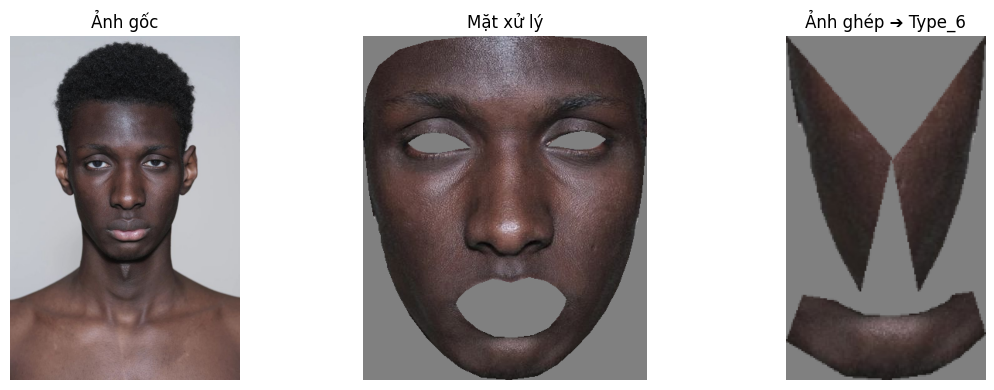

Dự đoán:  62%|██████▏   | 8/13 [00:02<00:01,  3.07it/s]

[66790b9551a1b9c2251874af7e273e53.jpg] ΔE giữa từng cặp:
  left vs right: 5.93
  left vs chin: 2.75
  right vs chin: 7.30
[66790b9551a1b9c2251874af7e273e53.jpg] ΔE trung bình: {'left': '4.34', 'chin': '5.02', 'right': '6.62'}
66790b9551a1b9c2251874af7e273e53.jpg 🧩 Dự đoán ➔ Type_4


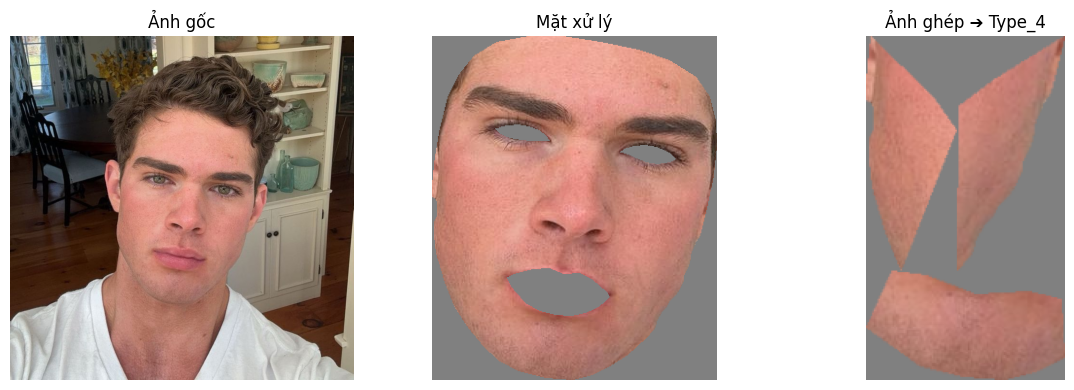

Dự đoán:  69%|██████▉   | 9/13 [00:02<00:01,  3.12it/s]

[93607d1dba4697a2c8a725945d7f14d7.jpg] ΔE giữa từng cặp:
  left vs right: 3.31
  left vs chin: 7.80
  right vs chin: 10.26
[93607d1dba4697a2c8a725945d7f14d7.jpg] ΔE trung bình: {'left': '5.56', 'right': '6.78', 'chin': '9.03'}
93607d1dba4697a2c8a725945d7f14d7.jpg 🧩 Dự đoán ➔ Type_4


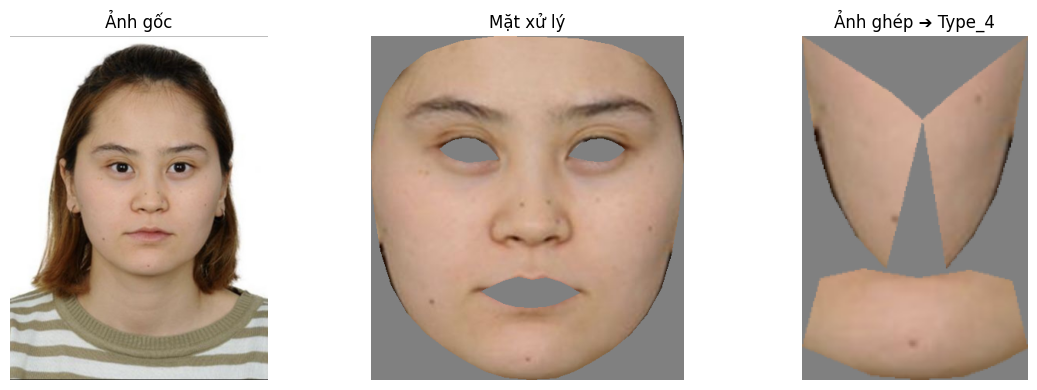

Dự đoán:  92%|█████████▏| 12/13 [00:03<00:00,  3.75it/s]

[f9a32231fdcca41802257c8a37a448fd.jpg] ΔE giữa từng cặp:
  left vs right: 7.75
  left vs chin: 9.77
  right vs chin: 10.36
[f9a32231fdcca41802257c8a37a448fd.jpg] ΔE trung bình: {'left': '8.76', 'right': '9.06', 'chin': '10.06'}
f9a32231fdcca41802257c8a37a448fd.jpg 🧩 Dự đoán ➔ Type_4
[p3.jpg] ΔE giữa từng cặp:
  left vs right: 9.22
  left vs chin: 15.81
  right vs chin: 10.19
[p3.jpg] ΔE trung bình: {'left': '12.51', 'right': '9.70', 'chin': '13.00'}
p3.jpg 🧩 Dự đoán ➔ Type_4
[v9.jpg] ΔE giữa từng cặp:
  left vs right: 7.69
  left vs chin: 18.08
  right vs chin: 16.08
[v9.jpg] ΔE trung bình: {'left': '12.89', 'right': '11.88', 'chin': '17.08'}
[v9.jpg] ✅ left & right gần nhau ➜ Loại bỏ vùng lệch: chin
v9.jpg 🧩 Dự đoán ➔ Type_4


Dự đoán: 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


✅ Đã lưu kết quả tại: results_combined_only.csv


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapipe as mp
from collections import OrderedDict
from skimage.color import rgb2lab

# ===== Cấu hình =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
class_names = ["Type_1", "Type_2", "Type_3", "Type_4", "Type_5", "Type_6"]

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[1].in_features, 128),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128, 6)
)
model.load_state_dict(torch.load("D:/KLTN/SKINTONE/mobilenetv2_best_cheek_chin.pth", map_location=device))
model.to(device)
model.eval()

LEFT_CHEEK = [234, 93, 132, 58, 172, 136, 205, 50]
RIGHT_CHEEK = [454, 323, 361, 288, 397, 365, 425, 280]
CHIN = [204,149,148,152,377,400,378,424,406,18,182,204]

def crop_region(image, landmarks, ids):
    h, w = image.shape[:2]
    pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in ids], np.int32)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    region = cv2.bitwise_and(image, image, mask=mask)
    gray_bg = np.full_like(image, 128)
    blended = np.where(mask[:, :, None] == 255, region, gray_bg)
    x, y, w_box, h_box = cv2.boundingRect(pts)
    return blended[y:y+h_box, x:x+w_box]

def is_valid_region(region, min_size=20, min_lightness=50):
    if region is None or region.size == 0:
        return False
    h, w = region.shape[:2]
    if h < min_size or w < min_size:
        return False
    lab = cv2.cvtColor(region, cv2.COLOR_RGB2Lab)
    L_mean = np.mean(lab[:, :, 0])
    return L_mean >= min_lightness

def get_lab_mean(region):
    lab = rgb2lab(region)
    return np.mean(lab[:, :, 0]), np.mean(lab[:, :, 1]), np.mean(lab[:, :, 2])

def delta_e(c1, c2):
    return np.linalg.norm(np.array(c1) - np.array(c2))

def remove_color_outlier(regions, threshold=6, debug_name=""):
    if len(regions) < 2:
        return regions

    lab_means = {k: get_lab_mean(v) for k, v in regions.items()}
    keys = list(lab_means.keys())

    if len(keys) == 2:
        return regions

    # Tính ΔE giữa từng cặp vùng
    pairwise_de = {
        (a, b): delta_e(lab_means[a], lab_means[b])
        for i, a in enumerate(keys)
        for j, b in enumerate(keys)
        if i < j
    }

    print(f"[{debug_name}] ΔE giữa từng cặp:")
    for (a, b), de in pairwise_de.items():
        print(f"  {a} vs {b}: {de:.2f}")

    # Tìm cặp vùng gần nhau nhất
    closest_pair = min(pairwise_de, key=pairwise_de.get)
    closest_de = pairwise_de[closest_pair]

    # Xác định vùng còn lại
    other = [k for k in keys if k not in closest_pair][0]
    d1 = delta_e(lab_means[other], lab_means[closest_pair[0]])
    d2 = delta_e(lab_means[other], lab_means[closest_pair[1]])

    print(f"[{debug_name}] ΔE trung bình: {{'{closest_pair[0]}': '{(d1 + closest_de)/2:.2f}', '{closest_pair[1]}': '{(d2 + closest_de)/2:.2f}', '{other}': '{(d1 + d2)/2:.2f}'}}")

    # Nếu vùng còn lại lệch xa cả hai vùng kia → loại
    if d1 > threshold and d2 > threshold:
        print(f"[{debug_name}] ✅ {closest_pair[0]} & {closest_pair[1]} gần nhau ➜ Loại bỏ vùng lệch: {other}")
        regions.pop(other)

    return regions





def predict_folder(folder_path, limit=10, save_csv="results_combined_only.csv"):
    mp_face_mesh = mp.solutions.face_mesh
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    os.makedirs("debug_combined", exist_ok=True)
    results_list = []
    count = 0

    for filename in tqdm(os.listdir(folder_path), desc="Dự đoán"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue

        path = os.path.join(folder_path, filename)
        image = cv2.imread(path)
        if image is None:
            continue
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ih, iw = img_rgb.shape[:2]

        result = face_mesh.process(img_rgb)
        if not result.multi_face_landmarks:
            print(f"{filename} ❌ Không tìm thấy khuôn mặt")
            continue
        landmarks = result.multi_face_landmarks[0].landmark

        # Tạo mặt nạ khuôn mặt (loại bỏ mắt-miệng)
        face_contour = [10,338,297,332,284,251,389,356,454,323,361,288,397,
                        365,379,378,400,377,152,148,176,149,150,136,172,
                        58,132,93,234,127,162,21,54,103,67,109]
        face_points = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in face_contour], np.int32)
        face_mask = np.zeros((ih, iw), dtype=np.uint8)
        cv2.fillPoly(face_mask, [face_points], 255)

        for region in [[33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7],
                       [362,398,384,385,386,387,388,466,263,249,390,373,374,380,381,382],
                       [61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146,61]]:
            pts = np.array([[int(landmarks[i].x * iw), int(landmarks[i].y * ih)] for i in region], np.int32)
            cv2.fillPoly(face_mask, [pts], 0)

        seg = selfie_segmentation.process(img_rgb)
        seg_mask = (seg.segmentation_mask > 0.9).astype(np.uint8) * 255
        seg_mask = cv2.GaussianBlur(seg_mask, (7, 7), sigmaX=3)
        seg_mask = (seg_mask > 127).astype(np.uint8) * 255

        comb_mask = cv2.bitwise_and(face_mask, seg_mask)
        masked = cv2.bitwise_and(img_rgb, img_rgb, mask=comb_mask)
        gray_bg = np.full_like(img_rgb, 128)
        img_with_gray_bg = np.where(comb_mask[:, :, None] == 255, masked, gray_bg)

        x, y, w_box, h_box = cv2.boundingRect(face_points)
        face_crop = img_with_gray_bg[y:y+h_box, x:x+w_box]

        regions = OrderedDict({
            "left": crop_region(img_with_gray_bg, landmarks, LEFT_CHEEK),
            "right": crop_region(img_with_gray_bg, landmarks, RIGHT_CHEEK),
            "chin": crop_region(img_with_gray_bg, landmarks, CHIN),
        })

        valid_regions = {k: v for k, v in regions.items() if is_valid_region(v)}
        valid_regions = remove_color_outlier(valid_regions, threshold=12, debug_name=filename)

        if len(valid_regions) < 2:
            print(f"{filename} ❌ Không đủ vùng hợp lệ sau khi loại lệch màu")
            continue

        target_h = 150
        top_row = []
        bottom_row = None
        for k in ["left", "right"]:
            if k in valid_regions:
                h, w = valid_regions[k].shape[:2]
                scale = target_h / h
                resized = cv2.resize(valid_regions[k], (int(w * scale), target_h))
                top_row.append(resized)
        if "chin" in valid_regions:
            chin = valid_regions["chin"]
            chin_h, chin_w = chin.shape[:2]
            scale_chin = (sum([img.shape[1] for img in top_row]) if top_row else chin_w) / chin_w
            bottom_row = cv2.resize(chin, (int(chin_w * scale_chin), int(chin_h * scale_chin)))

        combined = None
        if top_row:
            top = cv2.hconcat(top_row)
            if bottom_row is not None:
                bottom_resized = cv2.resize(bottom_row, (top.shape[1], bottom_row.shape[0]))
                combined = cv2.vconcat([top, bottom_resized])
            else:
                combined = top
        elif bottom_row is not None:
            combined = bottom_row

        pil_combined = Image.fromarray(combined).convert("RGB")
        input_tensor = val_transform(pil_combined).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()
            label = class_names[pred]
        print(f"{filename} 🧩 Dự đoán ➔ {label}")

        save_path = f"debug_combined/{os.path.splitext(filename)[0]}_combined.jpg"
        cv2.imwrite(save_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))

        results_list.append((filename, label))

        if count < limit:
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Ảnh gốc")
            axs[1].imshow(face_crop)
            axs[1].set_title("Mặt xử lý")
            axs[2].imshow(combined)
            axs[2].set_title(f"Ảnh ghép ➔ {label}")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
            count += 1

    if results_list:
        df = pd.DataFrame(results_list, columns=["Image", "Prediction"])
        df.to_csv(save_csv, index=False, encoding="utf-8-sig")
        print(f"\n✅ Đã lưu kết quả tại: {save_csv}")
    else:
        print("⚠️ Không ảnh nào được xử lý.")

# ===== Gọi thử =====
predict_folder("D:/KLTN/SKINTONE/public/test_images2", limit=10)

